# Load libraries

In [2]:
import pandas as pd
import numpy as np
from sklearn import metrics
from catboost import CatBoostClassifier
from sklearn.model_selection import train_test_split
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import seaborn as sns
from catboost import Pool
import itertools
from tqdm import tqdm
from sklearn.metrics import accuracy_score

import warnings
warnings.filterwarnings("ignore")

AttributeError: module 'matplotlib' has no attribute 'get_data_path'

# Read data

In [3]:
df = pd.read_csv('/content/drive/MyDrive/Internship_data/data.csv')
df = df.drop(columns = ['Product ID','TWF','HDF','PWF','OSF','RNF','UDI'])

# Data preparation

In [4]:
dummies = pd.get_dummies(df['Type'],prefix='Type')

In [5]:
df = pd.concat([df.drop(columns = ['Type']),dummies],axis = 1)

# Data analysis 

In [ ]:
fig = px.histogram(df, x="Machine failure",color='Machine failure')
fig.show()

In [ ]:
fig = make_subplots(rows=2, cols=3,subplot_titles = df.drop(
    columns = ['Machine failure',
               'Type_H',
               'Type_L',
               'Type_M']).columns)
row = 1
column = 1

for count, col in enumerate(df.drop(columns = ['Machine failure',
                                               'Type_H','Type_L',
                                               'Type_M']).columns):
  data1 = df[df['Machine failure'] == 0][col]
  data2 = df[df['Machine failure'] == 1][col]
  
  if count != 0:
    trace1 = go.Box(y=data1, marker=dict(color='blue'),name = 'No failure',
                    showlegend=False)
    trace2 = go.Box(y=data2, marker=dict(color='red'),name = 'Machine failure',
                    showlegend=False)
  else:
    trace1 = go.Box(y=data1, marker=dict(color='blue'),name = 'No failure')
    trace2 = go.Box(y=data2, marker=dict(color='red'),name = 'Machine failure')

  fig.add_trace(trace1, row=row, col=column)
  fig.add_trace(trace2, row=row, col=column)

  if column == 3:
    column=0
    row += 1
  column += 1

fig.update_layout(height=800, width=1200, title='Comparing all features by Machine failure')
fig.show()

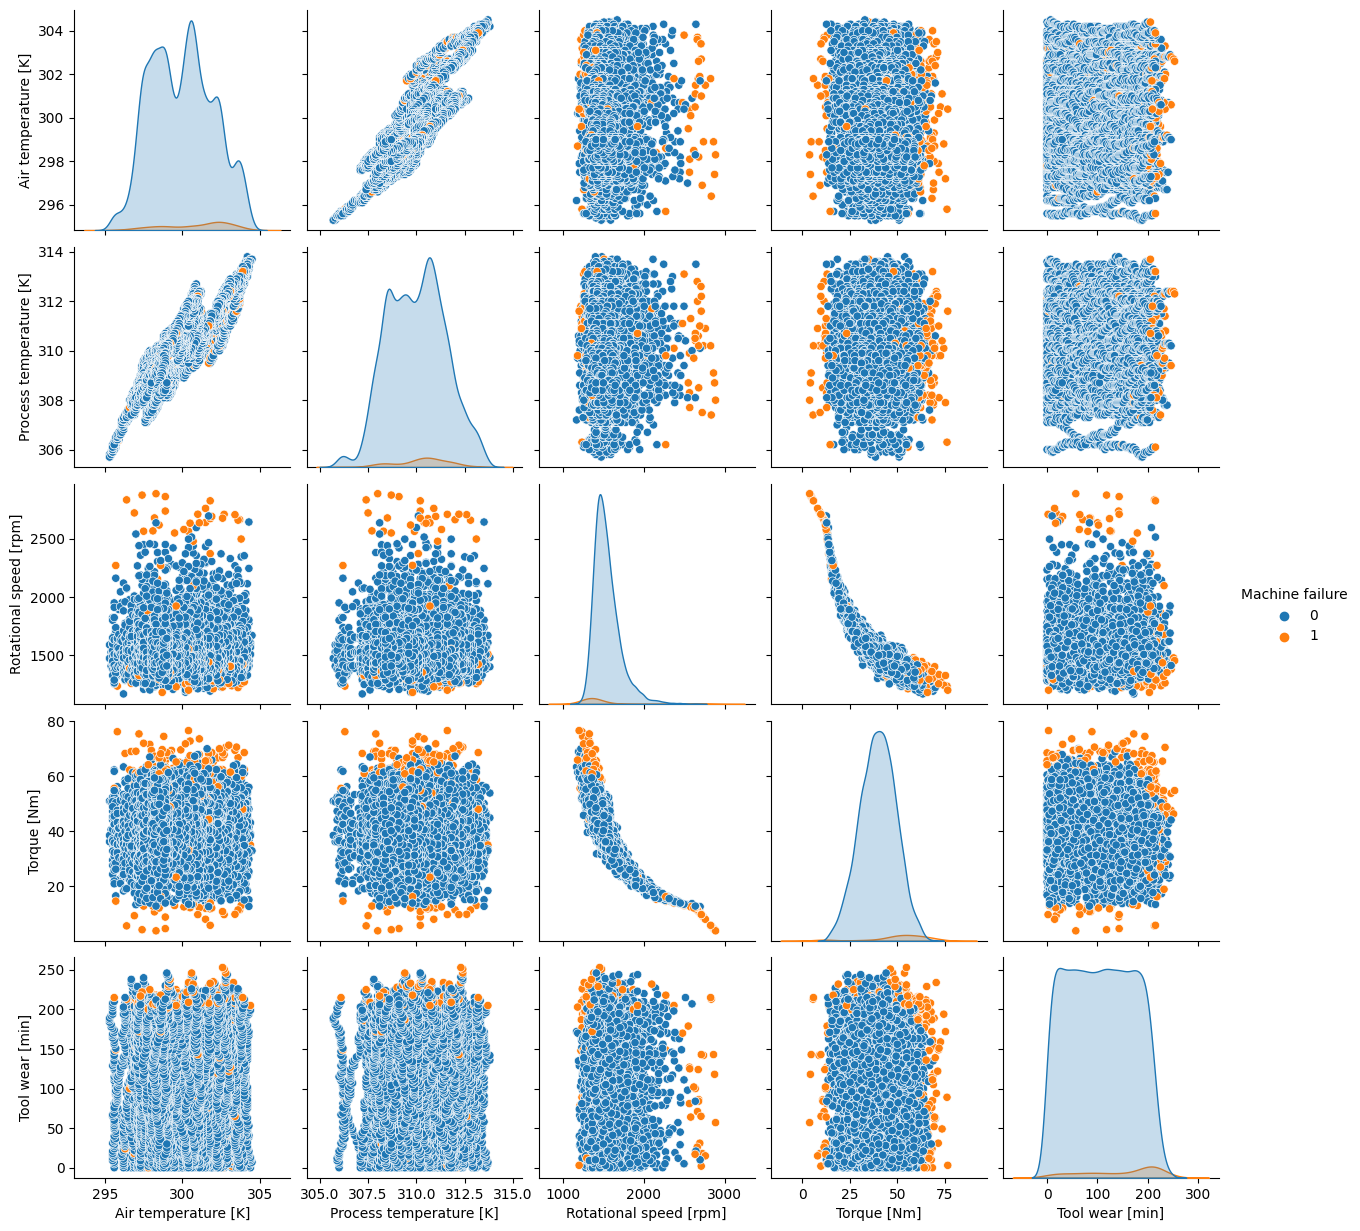

In [ ]:
sns.pairplot(df.drop(columns = ['Type_H','Type_L','Type_M']),
             hue="Machine failure")

# Feature engineering

In [6]:
df['Difference_of_temperature '] = df['Process temperature [K]'] - df['Air temperature [K]']

In [7]:
df_fe = df.copy()
for col in df.drop(columns = ['Machine failure','Type_H','Type_L','Type_M']):
  df_fe[col+'^2'] = df_fe[col]*df_fe[col]

In [8]:
col_pairs = list(itertools.combinations(df_fe.drop(columns = ['Machine failure']).columns, 2))

In [9]:
for pair in col_pairs:
    col_name = pair[0] + '*' + pair[1]
    df_fe[col_name] = df_fe[pair[0]] * df_fe[pair[1]]

In [10]:
def upsampling(X_train, y_train):
  df = pd.concat([X_train, y_train],axis = 1)
  # Count the number of samples in each class
  class_counts = df['Machine failure'].value_counts()

  # Determine the minority and majority class
  minority_class = class_counts.idxmin()
  majority_class = class_counts.idxmax()

  # Upsample the minority class with replacement
  minority_df = df[df['Machine failure'] == minority_class]
  upsampled_df = pd.concat(
      [df] + [minority_df.sample(n=class_counts[majority_class] - class_counts[minority_class],
                                replace=True)], axis=0)

  # Shuffle the upsampled data
  upsampled_df = upsampled_df.sample(frac=1).reset_index(drop = True)
  return upsampled_df.drop(columns = ['Machine failure']), upsampled_df['Machine failure']

# Train Catboost

## Test data without upsampling

### Find feature importance

In [ ]:
def check_result(model,X_test,y_test):
  fpr, tpr, thresholds = metrics.roc_curve(y_test, model.predict(X_test))
  result = metrics.auc(fpr, tpr)
  acc = accuracy_score(y_test, model.predict(X_test))
  print(f'Accuracy = {acc}, AUC = {result}')
  return result

In [ ]:
CatBoost = CatBoostClassifier(verbose=False)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(df.drop(columns = ['Machine failure']),
                                                    df['Machine failure'],
                                                    test_size=0.33,
                                                    random_state=42,
                                                    stratify = df['Machine failure'])

train_pool = Pool(data=X_train, label=y_train)

In [ ]:
CatBoost.fit(train_pool)

feature_importance = pd.DataFrame({'feature_importance': CatBoost.get_feature_importance(train_pool), 
              'feature_names': X_test.columns}).sort_values(by=['feature_importance'], 
                                                       ascending=False)
              
check_result(CatBoost, X_test, y_test )

Accuracy = 0.9906060606060606, AUC = 0.9003741709983868


0.9003741709983868

### Fing best amount of features

In [ ]:
def search_num_features(df, feature_importance, upsamp_func = False, step = 3):
  best_score = 0
  best_num_features = 0
  acc = 0
  for num_col in tqdm(range(1, len(feature_importance), step)):
    features = list(feature_importance.iloc[:num_col,:]['feature_names'])
    data = df[features + ['Machine failure']]
    X_train, X_test, y_train, y_test = train_test_split(data.drop(columns = ['Machine failure']),
                                                        data['Machine failure'],
                                                        test_size=0.33,
                                                        random_state=42,
                                                        stratify = df['Machine failure'])
    if upsamp_func == True:
      X_train, y_train = upsampling(X_train, y_train)

    train_pool = Pool(data=X_train, label=y_train)
    CatBoost = CatBoostClassifier(verbose=False)
    CatBoost.fit(train_pool)
    metric = check_result(CatBoost, X_test, y_test)
    acc_current = accuracy_score(y_test, CatBoost.predict(X_test))
    if metric > best_score:
      best_score = metric
      best_num_features = num_col
    if acc < acc_current:
      acc = acc_current
  print(f'Best AUC - {best_score}, num_features - {best_num_features}, acc = {acc}')

In [ ]:
search_num_features(df,feature_importance, step = 3)

  2%|▎         | 1/40 [00:03<02:25,  3.72s/it]

Accuracy = 0.9721212121212122, AUC = 0.6151303997132103


  5%|▌         | 2/40 [00:08<02:34,  4.08s/it]

Accuracy = 0.9778787878787879, AUC = 0.7257965137121347


  8%|▊         | 3/40 [00:11<02:27,  3.98s/it]

Accuracy = 0.9790909090909091, AUC = 0.7393462089980284


 10%|█         | 4/40 [00:16<02:36,  4.35s/it]

Accuracy = 0.9872727272727273, AUC = 0.8684968184262413


 12%|█▎        | 5/40 [00:24<03:08,  5.38s/it]

Accuracy = 0.9881818181818182, AUC = 0.8861971231403478


 15%|█▌        | 6/40 [00:29<03:06,  5.48s/it]

Accuracy = 0.9887878787878788, AUC = 0.8822033518551711


 18%|█▊        | 7/40 [00:39<03:46,  6.86s/it]

Accuracy = 0.9881818181818182, AUC = 0.8775822279978491


 20%|██        | 8/40 [00:49<04:10,  7.81s/it]

Accuracy = 0.9890909090909091, AUC = 0.8909750851407062


 22%|██▎       | 9/40 [00:57<04:01,  7.79s/it]

Accuracy = 0.9918181818181818, AUC = 0.9139238662842804


 25%|██▌       | 10/40 [01:08<04:25,  8.83s/it]

Accuracy = 0.9918181818181818, AUC = 0.9139238662842804


 28%|██▊       | 11/40 [01:21<04:54, 10.14s/it]

Accuracy = 0.9912121212121212, AUC = 0.9049952948557088


 30%|███       | 12/40 [01:33<05:03, 10.82s/it]

Accuracy = 0.9912121212121212, AUC = 0.9049952948557088


 32%|███▎      | 13/40 [01:47<05:19, 11.84s/it]

Accuracy = 0.9912121212121212, AUC = 0.9049952948557088


 35%|███▌      | 14/40 [02:02<05:32, 12.77s/it]

Accuracy = 0.9912121212121212, AUC = 0.9049952948557088


 38%|███▊      | 15/40 [02:18<05:39, 13.57s/it]

Accuracy = 0.9918181818181818, AUC = 0.909616418713031


 40%|████      | 16/40 [02:39<06:18, 15.77s/it]

Accuracy = 0.9912121212121212, AUC = 0.9049952948557088


 42%|████▎     | 17/40 [02:55<06:09, 16.05s/it]

Accuracy = 0.9915151515151515, AUC = 0.9094595805699947


 45%|████▌     | 18/40 [03:14<06:11, 16.87s/it]

Accuracy = 0.9912121212121212, AUC = 0.9049952948557088


 48%|████▊     | 19/40 [03:32<06:01, 17.20s/it]

Accuracy = 0.990909090909091, AUC = 0.9005310091414231


 50%|█████     | 20/40 [03:50<05:48, 17.41s/it]

Accuracy = 0.9912121212121212, AUC = 0.9049952948557088


 52%|█████▎    | 21/40 [04:09<05:42, 18.03s/it]

Accuracy = 0.9912121212121212, AUC = 0.9049952948557088


 55%|█████▌    | 22/40 [04:31<05:45, 19.19s/it]

Accuracy = 0.9912121212121212, AUC = 0.9049952948557088


 57%|█████▊    | 23/40 [04:53<05:36, 19.81s/it]

Accuracy = 0.9912121212121212, AUC = 0.9049952948557088


 60%|██████    | 24/40 [05:18<05:44, 21.53s/it]

Accuracy = 0.9915151515151515, AUC = 0.9094595805699947


 62%|██████▎   | 25/40 [05:42<05:35, 22.36s/it]

Accuracy = 0.9915151515151515, AUC = 0.9094595805699947


 65%|██████▌   | 26/40 [06:06<05:18, 22.73s/it]

Accuracy = 0.9915151515151515, AUC = 0.9094595805699947


 68%|██████▊   | 27/40 [06:33<05:13, 24.09s/it]

Accuracy = 0.9918181818181818, AUC = 0.9139238662842804


 70%|███████   | 28/40 [07:19<06:06, 30.53s/it]

Accuracy = 0.9915151515151515, AUC = 0.9094595805699947


 72%|███████▎  | 29/40 [07:45<05:22, 29.28s/it]

Accuracy = 0.9915151515151515, AUC = 0.9094595805699947


 75%|███████▌  | 30/40 [08:11<04:43, 28.39s/it]

Accuracy = 0.9912121212121212, AUC = 0.9049952948557088


 78%|███████▊  | 31/40 [08:39<04:14, 28.24s/it]

Accuracy = 0.9912121212121212, AUC = 0.9049952948557088


 80%|████████  | 32/40 [09:07<03:45, 28.16s/it]

Accuracy = 0.9915151515151515, AUC = 0.9094595805699947


 82%|████████▎ | 33/40 [09:36<03:17, 28.19s/it]

Accuracy = 0.9915151515151515, AUC = 0.9094595805699947


 85%|████████▌ | 34/40 [10:04<02:48, 28.16s/it]

Accuracy = 0.9912121212121212, AUC = 0.9049952948557088


 88%|████████▊ | 35/40 [10:32<02:21, 28.25s/it]

Accuracy = 0.9915151515151515, AUC = 0.9094595805699947


 90%|█████████ | 36/40 [11:02<01:55, 28.77s/it]

Accuracy = 0.9912121212121212, AUC = 0.9049952948557088


 92%|█████████▎| 37/40 [11:49<01:42, 34.06s/it]

Accuracy = 0.9912121212121212, AUC = 0.9093027424269583


 95%|█████████▌| 38/40 [12:22<01:07, 33.76s/it]

Accuracy = 0.990909090909091, AUC = 0.9048384567126725


 98%|█████████▊| 39/40 [12:51<00:32, 32.59s/it]

Accuracy = 0.9912121212121212, AUC = 0.9049952948557088


## Test data with upsampling

### Find feature importance

In [ ]:
CatBoost = CatBoostClassifier(verbose=False)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(df.drop(columns = ['Machine failure']),
                                                    df['Machine failure'],
                                                    test_size=0.33,
                                                    random_state=42,
                                                    stratify = df['Machine failure'])
X_train, y_train = upsampling(X_train, y_train)

train_pool = Pool(data=X_train, label=y_train)

In [ ]:
CatBoost.fit(train_pool)

feature_importance = pd.DataFrame({'feature_importance': CatBoost.get_feature_importance(train_pool), 
              'feature_names': X_test.columns}).sort_values(by=['feature_importance'], 
                                                       ascending=False)
              
check_result(CatBoost, X_test, y_test)

### Fing best amount of features

In [ ]:
search_num_features(df, feature_importance,upsamp_func = True, step = 3)

  2%|▎         | 1/40 [00:04<02:48,  4.32s/it]

Accuracy = 0.7790909090909091, AUC = 0.7521341190177451


  5%|▌         | 2/40 [00:12<04:05,  6.45s/it]

Accuracy = 0.9636363636363636, AUC = 0.7787293869869152


  8%|▊         | 3/40 [00:18<03:55,  6.36s/it]

Accuracy = 0.9645454545454546, AUC = 0.7404328732747804


 10%|█         | 4/40 [00:28<04:34,  7.64s/it]

Accuracy = 0.9878787878787879, AUC = 0.8860402849973114


 12%|█▎        | 5/40 [00:37<04:53,  8.38s/it]

Accuracy = 0.9872727272727273, AUC = 0.9029563989962358


 15%|█▌        | 6/40 [00:46<04:49,  8.52s/it]

Accuracy = 0.99, AUC = 0.9172902849973114


 18%|█▊        | 7/40 [00:57<05:10,  9.40s/it]

Accuracy = 0.9887878787878788, AUC = 0.9080480372826671


 20%|██        | 8/40 [01:09<05:27, 10.23s/it]

Accuracy = 0.9893939393939394, AUC = 0.9126691611399891


 22%|██▎       | 9/40 [01:22<05:40, 10.99s/it]

Accuracy = 0.9878787878787879, AUC = 0.9032700752823087


 25%|██▌       | 10/40 [01:35<05:53, 11.77s/it]

Accuracy = 0.9869696969696969, AUC = 0.8941846657107009


 28%|██▊       | 11/40 [01:50<06:02, 12.48s/it]

Accuracy = 0.9875757575757576, AUC = 0.9074206847105215


 30%|███       | 12/40 [02:04<06:09, 13.21s/it]

Accuracy = 0.9884848484848485, AUC = 0.9165060942821295


 32%|███▎      | 13/40 [02:20<06:16, 13.94s/it]

Accuracy = 0.9872727272727273, AUC = 0.9072638465674852


 35%|███▌      | 14/40 [02:38<06:37, 15.28s/it]

Accuracy = 0.9878787878787879, AUC = 0.907577522853558


 38%|███▊      | 15/40 [02:56<06:42, 16.10s/it]

Accuracy = 0.9860606060606061, AUC = 0.8937141512815917


 40%|████      | 16/40 [03:15<06:41, 16.73s/it]

Accuracy = 0.9872727272727273, AUC = 0.9029563989962358


 42%|████▎     | 17/40 [03:35<06:50, 17.83s/it]

Accuracy = 0.9869696969696969, AUC = 0.9114144559956981


 45%|████▌     | 18/40 [03:54<06:40, 18.21s/it]

Accuracy = 0.9887878787878788, AUC = 0.9123554848539164


 48%|████▊     | 19/40 [04:16<06:45, 19.31s/it]

Accuracy = 0.9887878787878788, AUC = 0.9037405897114178


 50%|█████     | 20/40 [04:37<06:33, 19.67s/it]

Accuracy = 0.9893939393939394, AUC = 0.9040542659974906


 52%|█████▎    | 21/40 [04:59<06:31, 20.63s/it]

Accuracy = 0.9918181818181818, AUC = 0.9182313138555297


 55%|█████▌    | 22/40 [05:23<06:26, 21.48s/it]

Accuracy = 0.9921212121212121, AUC = 0.9183881519985662


 57%|█████▊    | 23/40 [05:46<06:15, 22.10s/it]

Accuracy = 0.99, AUC = 0.9172902849973114


 60%|██████    | 24/40 [06:10<06:01, 22.62s/it]

Accuracy = 0.9903030303030304, AUC = 0.9174471231403479


 62%|██████▎   | 25/40 [06:36<05:52, 23.50s/it]

Accuracy = 0.9906060606060606, AUC = 0.9176039612833842


 65%|██████▌   | 26/40 [07:02<05:40, 24.31s/it]

Accuracy = 0.990909090909091, AUC = 0.9048384567126725


 68%|██████▊   | 27/40 [07:29<05:26, 25.12s/it]

Accuracy = 0.9896969696969697, AUC = 0.9128259992830255


 70%|███████   | 28/40 [07:56<05:08, 25.68s/it]

Accuracy = 0.9893939393939394, AUC = 0.9126691611399891


 72%|███████▎  | 29/40 [08:24<04:48, 26.27s/it]

Accuracy = 0.9912121212121212, AUC = 0.9136101899982075


 75%|███████▌  | 30/40 [08:52<04:30, 27.05s/it]

Accuracy = 0.9906060606060606, AUC = 0.9089890661408854


 78%|███████▊  | 31/40 [09:23<04:11, 27.97s/it]

Accuracy = 0.990909090909091, AUC = 0.9134533518551712


 80%|████████  | 32/40 [09:52<03:47, 28.40s/it]

Accuracy = 0.9906060606060606, AUC = 0.9132965137121348


 82%|████████▎ | 33/40 [10:22<03:21, 28.79s/it]

Accuracy = 0.990909090909091, AUC = 0.9220682469976698


 85%|████████▌ | 34/40 [10:57<03:04, 30.77s/it]

Accuracy = 0.990909090909091, AUC = 0.9177607994264206


 88%|████████▊ | 35/40 [11:28<02:33, 30.75s/it]

Accuracy = 0.9906060606060606, AUC = 0.9132965137121348


 90%|█████████ | 36/40 [11:59<02:03, 30.90s/it]

Accuracy = 0.990909090909091, AUC = 0.9177607994264206


 92%|█████████▎| 37/40 [12:32<01:34, 31.61s/it]

Accuracy = 0.9906060606060606, AUC = 0.9176039612833842


 95%|█████████▌| 38/40 [13:04<01:03, 31.61s/it]

Accuracy = 0.990909090909091, AUC = 0.9177607994264206


 98%|█████████▊| 39/40 [13:37<00:32, 32.09s/it]

Accuracy = 0.9915151515151515, AUC = 0.9180744757124933


100%|██████████| 40/40 [14:09<00:00, 21.24s/it]

Accuracy = 0.9906060606060606, AUC = 0.9089890661408854
Best AUC - 0.9220682469976698, num_features - 97, acc = 0.9921212121212121


# Defining of neural network

In [13]:
df.shape

(10000, 10)